### Further wrangle with the features 

In [1]:
import time
import datetime
import copy
import numpy as np
import math

import pandas as pd
import json
from bson.json_util import dumps
from fastparquet import ParquetFile,write
import matplotlib.pyplot as plt
from tqdm import tqdm

In [14]:
pf=ParquetFile('full_2nd_events4ml_110419.parq')

In [15]:
udf=pf.to_pandas()

In [16]:
udf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38186 entries, 11049447 to 9968570
Data columns (total 24 columns):
category                 38186 non-null int64
past                     38186 non-null int32
votes                    38186 non-null int64
is_eventbrite            38186 non-null int32
is_free                  38186 non-null int32
doors                    38186 non-null int32
sold_out                 38186 non-null int32
venue.id                 38186 non-null int64
venue.popularity         38186 non-null float64
venue.zip                38186 non-null int64
ticket_allages           38186 non-null int32
ticket_price_low         38186 non-null float64
ticket_price_max         38186 non-null float64
min_age                  38186 non-null int32
artist.popularity.sum    38186 non-null float64
artist.popularity.avg    38186 non-null float64
artist.popularity.max    38186 non-null float64
dow                      38186 non-null int64
doy                      38186 non-null in

In [2]:
pf=ParquetFile('do512_10-3-2019-10-3-2018.parquet')
df2=pf.to_pandas()

In [3]:
df2=df2[['venue.id', 'venue.title','venue.address',
       'venue.city', 'venue.state', 'venue.zip','venue.latitude','venue.longitude','id']]

In [4]:
df2=df2.drop_duplicates(subset='id')

#### Parse the information of event address

In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40703 entries, 0 to 41864
Data columns (total 9 columns):
venue.id           40703 non-null int64
venue.title        40703 non-null object
venue.address      39923 non-null object
venue.city         39997 non-null object
venue.state        39997 non-null object
venue.zip          39923 non-null object
venue.latitude     34020 non-null float64
venue.longitude    34021 non-null float64
id                 40703 non-null int64
dtypes: float64(2), int64(2), object(5)
memory usage: 3.1+ MB


In [6]:
## fix all kinds of the 'austin' back to 'Austin'
rep=['AUSTIN','Ausitn','Austin ','AUSTIN ','Austin TX','78701','Austin,','Austin, ','Austin, TX','austin',' Austin','Austi',' AUSTIN']
df2.loc[df2['venue.city'].isin(rep),'venue.city']='Austin'

In [7]:
# include only specific cities/counties
incities=['Austin','Round Rock','Cedar Park','Pflugerville','Leander','Spicewood','West Lake Hills','Westlake Hills',' Round Rock',' Round Rock','Leander ','Bee cave','Bee Cave']

In [8]:
# fix some more city names
rep2=[' Round Rock']
df2.loc[df2['venue.city'].isin(rep2),'venue.city']='Round Rock'
rep2=['Leander ']
df2.loc[df2['venue.city'].isin(rep2),'venue.city']='Leander'
rep2=['Bee cave']
df2.loc[df2['venue.city'].isin(rep2),'venue.city']='Bee Cave'
rep2=['Westlake Hills']
df2.loc[df2['venue.city'].isin(rep2),'venue.city']='West Lake Hills'

In [9]:
df2.loc[df2['venue.city'].isin(incities)]['venue.city'].value_counts()

Austin             37370
Round Rock           293
Cedar Park           230
Pflugerville         139
Bee Cave              60
Leander               42
Spicewood             38
West Lake Hills       14
Name: venue.city, dtype: int64

In [10]:
len(df2)

40703

In [11]:
# build a mask based on cities to exclude non-greater-Austin events
mask=df2['venue.city'].isin(incities)
# first mask the original df for such events
#udf=udf[mask.values]

In [12]:
df2=df2[mask]

In [17]:
print("after masking:",len(udf),sum(mask))

after masking: 38186 38186


In [18]:
#  check the 'secret locations' > to take out all secrete location events
dump = df2['venue.address'].values

In [19]:
mask3= []
secrets = []
for i,item in enumerate(dump):
    if item:
        if 'secret' in item: 
            print(item)
            secrets+=[item]
        mask3+=[True]
    else:
        mask3+=[False]

In [20]:
print("total events with address:",sum(mask3),"out of:",len(df2), "events.")
print("total number of events in secret locations:",len(secrets))

total events with address: 37975 out of: 38186 events.
total number of events in secret locations: 0


In [21]:
# filter out the no address locations, first display
a=pd.Series(mask3)
df2[list(~a)]['venue.title'].value_counts()

Austin                                      74
The Museum of Human Achievement             36
TBA                                         29
Lady Bird Lake                              11
All Austin Area Pluckers                     8
Barton Creek Greenbelt                       6
All Austin Area Cover 3                      5
Mueller Austin                               4
All Austin Area Lick Honest Ice Creams       4
Lake Travis                                  4
Gender and Sexuality Center                  3
All Lavaca Street Bar Locations              2
Auditorium Shores & Republic Square Park     2
All Austin Area P. Terrys                    2
6th Street                                   2
Fox 7 - Good Day Austin                      2
2511 Diaz Street                             2
Austin Sports and Social Club                2
Walsh Landing                                1
ATX Sports & Adventures                      1
Austin Chuy's Locations                      1
All Austin Ar

In [22]:
# eliminate the ones without lat/lon 
check = df2['venue.latitude'].values
#mask4= [True for x in list(check) if x!=np.nan else False ]

In [23]:
mask4=[]
for item in check:
    if np.isnan(item):
        mask4+= [False]
    else: mask4+=[True]

In [27]:
print("total number of event locations with lat/lon information:",sum(mask4),"out of :",len(df2))
print("proportion of events not with lat/lon:",(len(df2)-sum(mask4))/len(df2)*100,"%")

total number of event locations with lat/lon information: 32880 out of : 38186
proportion of events not with lat/lon: 13.89514481747237 %


In [111]:
from scipy.stats import skew, skewtest
print("skewness of target votes:",skew(udf['votes']))
print("skew test:",skewtest(udf['votes']))

skewness of target votes: 40.05724228208327
skew test: SkewtestResult(statistic=277.3458192023687, pvalue=0.0)


In [28]:
# filter down to total number of events with good location info
udf=udf[mask4]

In [29]:
print("after masking:",len(udf),len(mask4))

after masking: 32880 38186


### Check the distribution of the votes(target)

Text(0, 0.5, 'event counts')

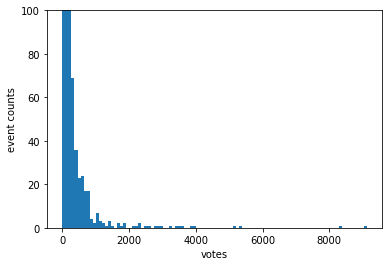

In [119]:
# plot the votes distribution after cleanup of cities
# plot votes distribution for all data
n_bins = 100
x=udf.votes.values
# subset votes to those not 1
xx = [c for c in x if c>0]
fig = plt.hist(xx,bins=n_bins)
plt.ylim([0,100])
plt.xlabel('votes')
plt.ylabel('event counts')
#plt.xlim([1000,9000])

In [123]:
xx=[x+1 for x in udf.votes.values]

#### Taking a clog of the votes

Text(0, 0.5, 'event counts')

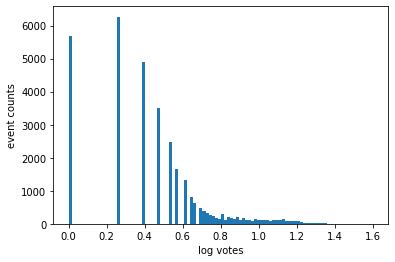

In [125]:
# perform a log transformation on the votes
# observe such transformation changes the distribution
fig = plt.hist(np.log(np.log10(xx)+1),bins=n_bins)
#plt.ylim([0,80])
plt.xlabel('log votes')
plt.ylabel('event counts')

#### It's a skewed distribution, and popular events are rare events

In [152]:
# get a sense of the votes
print("votes over 50:",sum(x>50)/len(x)*100,"%")
print("votes over 100:",sum(x>100)/len(x)*100,"%")
print("votes over 500:",sum(x>500)/len(x)*100,"%")
print("minimum of votes:",min(x),",total number of minimums:",sum(x==0),",accounts for:",sum(x==0)/len(x)*100,"%")
print("votes over 1500:",sum(x>1500),sum(x>1500)/len(x)*100,"%")

votes over 50: 5.31021897810219 %
votes over 100: 3.0565693430656937 %
votes over 500: 0.3588807785888078 %
minimum of votes: 0 ,total number of minimums: 5675 ,accounts for: 17.259732360097324 %
votes over 1500: 24 0.072992700729927 %


In [212]:
np.mean(udf['votes'])

15.429957420924573

In [168]:
# scaling on the features
threshold=200
usecols=list(udf.columns.values)
usecols.remove('votes')
usecols.remove('ev_id')
udf_x=udf[usecols]
udf_y=udf[['votes']].values
udf_y=[0 if x<threshold else 1 for x in list(udf_y)]
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler()
X_scaler.fit(udf_x)
udf_scX=X_scaler.transform(udf_x)

In [169]:
# gauge the default classification problem (no resample of two classes)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(udf_scX, udf_y, stratify=udf_y,test_size=0.3, random_state=12)

In [170]:
from sklearn.ensemble import RandomForestClassifier
RFClass=RandomForestClassifier()

In [171]:
RFClass.fit(X_train, y_train)

C:\Users\z0043H7B\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [172]:
pred_train_y= RFClass.predict(X_train)
pred_test_y= RFClass.predict(X_test)

In [173]:
# check performance on confusion matrix
from sklearn.metrics import confusion_matrix,classification_report,precision_recall_curve
print("confusion matrix:",confusion_matrix(y_test, pred_test_y))
print("other metrics:",classification_report(y_test, pred_test_y))

confusion matrix: [[9740    9]
 [  97   18]]
other metrics:               precision    recall  f1-score   support

           0       0.99      1.00      0.99      9749
           1       0.67      0.16      0.25       115

    accuracy                           0.99      9864
   macro avg       0.83      0.58      0.62      9864
weighted avg       0.99      0.99      0.99      9864



In [175]:
print("correct percentage for TP:",18/(9+18)*100,"%")
print("correct percentage for TN:",9740/(9740+97)*100,"%")

correct percentage for TP: 66.66666666666666 %
correct percentage for TN: 99.01392701026735 %


(0.0, 1.0)

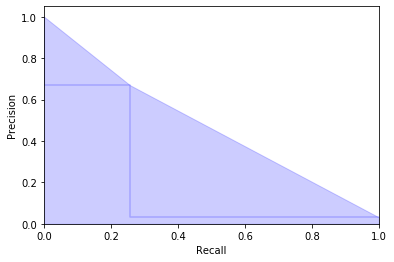

In [61]:
# plot precision/recall curve
from inspect import signature
precision, recall, _ = precision_recall_curve(y_test, pred_test_y)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
#plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [176]:
# try weighted RF classifier
RFClass2=RandomForestClassifier(class_weight='balanced')
RFClass2.fit(X_train, y_train)

C:\Users\z0043H7B\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [177]:
pred_train_y= RFClass2.predict(X_train)
pred_test_y= RFClass2.predict(X_test)

In [178]:
print("confusion matrix:",confusion_matrix(y_test, pred_test_y))
print("other metrics:",classification_report(y_test, pred_test_y))

confusion matrix: [[9746    3]
 [ 100   15]]
other metrics:               precision    recall  f1-score   support

           0       0.99      1.00      0.99      9749
           1       0.83      0.13      0.23       115

    accuracy                           0.99      9864
   macro avg       0.91      0.57      0.61      9864
weighted avg       0.99      0.99      0.99      9864



In [72]:
print("correct percentage for TP:",77/(20+77)*100,"%")
print("correct percentage for TN:",9536/(231+9536)*100,"%")

correct percentage for TP: 79.38144329896907 %
correct percentage for TN: 97.6348930070646 %


In [191]:
# test with random subsampling of the low votes and then do classification again
print(len(ldf),len(hdf))
subldf=ldf.sample(len(hdf))   # random sampling
print(len(subldf),len(hdf)) 
# reconcate and then shuffle
subdf = pd.concat([subldf, hdf], axis=0)
subdf=subdf.sample(frac=1)

32670 210
210 210


In [204]:
usecols=list(subdf.columns.values)
usecols.remove('votes')
usecols.remove('ev_id')
subdf_x=subdf[usecols]
subdf_y=subdf[['votes']].values
subdf_y=[0 if x<threshold else 1 for x in list(subdf_y)]
X_scaler = MinMaxScaler()
X_scaler.fit(subdf_x)
subdf_scX=X_scaler.transform(subdf_x)
X_train, X_test, y_train, y_test = train_test_split(subdf_scX, subdf_y,test_size=0.3, random_state=12)

In [209]:
RFClass3=RandomForestClassifier(random_state=12)
RFClass3.fit(X_train, y_train)

C:\Users\z0043H7B\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=12, verbose=0,
                       warm_start=False)

In [210]:
pred_train_y= RFClass3.predict(X_train)
pred_test_y= RFClass3.predict(X_test)

In [211]:
print("confusion matrix:",confusion_matrix(y_test, pred_test_y))
print("other metrics:",classification_report(y_test, pred_test_y))

confusion matrix: [[58  8]
 [10 50]]
other metrics:               precision    recall  f1-score   support

           0       0.85      0.88      0.87        66
           1       0.86      0.83      0.85        60

    accuracy                           0.86       126
   macro avg       0.86      0.86      0.86       126
weighted avg       0.86      0.86      0.86       126



(0.0, 1.0)

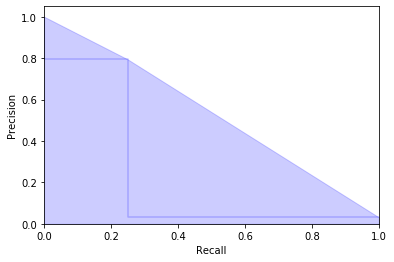

In [73]:
# plot precision/recall curve
precision, recall, _ = precision_recall_curve(y_test, pred_test_y)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
#plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [202]:
#from pyod.models.pca import PCA
from sklearn.decomposition import PCA

In [143]:
# subsetting data into two groups of events
hdf = udf.loc[udf['votes']>= 300]
ldf = udf.loc[udf['votes']< 300]

In [179]:
print("proportions of high votes and low votes:",len(hdf)/len(udf)*100,"%,",len(ldf)/len(udf)*100,"%")
print("total number on low votes:",len(ldf))
print("total number on high votes:",len(hdf))

proportions of high votes and low votes: 0.6386861313868614 %, 99.36131386861314 %
total number on low votes: 32670
total number on high votes: 210


Text(0, 0.5, 'event counts')

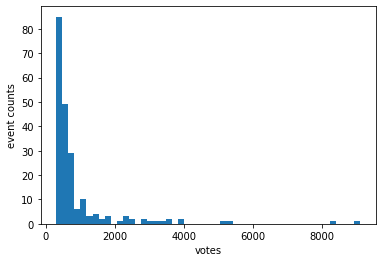

In [145]:
# preliminary test on predicting the votes for high-vote class:
# seperation of columns:
usecolns = list(hdf.columns.values)
usecolns.remove('votes')
usecolns.remove('ev_id')
hdf_X = hdf[usecolns]
hdf_y = hdf['votes']
# plot the high-vote distributions
n_bins = 50
# subset votes to those not 1
fig = plt.hist(hdf_y,bins=n_bins)
#plt.ylim([0,100])
plt.xlabel('votes')
plt.ylabel('event counts')

Text(0, 0.5, 'event counts')

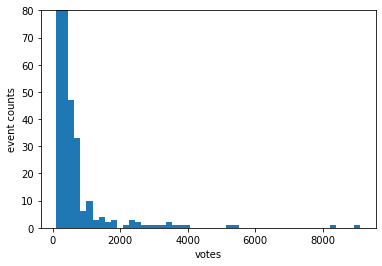

In [89]:
fig = plt.hist(hdf_y,bins=n_bins)
plt.ylim([0,80])
plt.xlabel('votes')
plt.ylabel('event counts')

Text(0, 0.5, 'event counts')

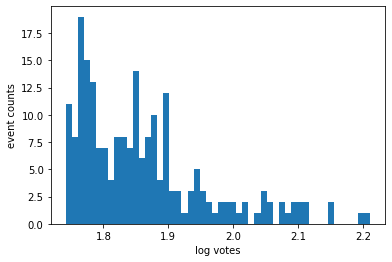

In [167]:
# perform a log transformation on the votes
# observe such transformation changes the distribution
a=np.log(np.log(hdf_y+1))
fig = plt.hist(a,bins=n_bins)
#plt.ylim([0,80])
plt.xlabel('log votes')
plt.ylabel('event counts')

In [163]:
print("skewness of target votes(clogged):",skew(a))
print("skew test:",skewtest(a))

skewness of target votes(clogged): 1.2311531462518404
skew test: SkewtestResult(statistic=6.076270377282248, pvalue=1.2300993648150564e-09)


Text(0, 0.5, 'event counts')

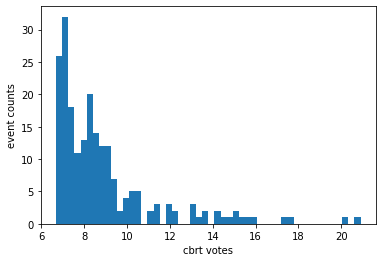

In [165]:
# try square-root transform
a=np.cbrt(hdf_y)
fig = plt.hist(a,bins=n_bins)
#plt.ylim([0,80])
plt.xlabel('cbrt votes')
plt.ylabel('event counts')

In [147]:
# start on regression method for the high-votes
# scaling the features
X_scaler = MinMaxScaler()
X_scaler.fit(hdf_X)
hdf_scX=X_scaler.transform(hdf_X)
X_train, X_test, y_train, y_test = train_test_split(hdf_scX, hdf_y, test_size=0.3, random_state=12)

In [148]:
print("number of total samples:",len(hdf_X), ", training samples:",len(X_train),",test samples:",len(X_test))

number of total samples: 210 , training samples: 147 ,test samples: 63


In [149]:
# set up regressor
from sklearn.ensemble import RandomForestRegressor
RFReg0=RandomForestRegressor(random_state=12,verbose=10)

In [150]:
RFReg0.fit(X_train,y_train)

C:\Users\z0043H7B\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 3 of 10


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


building tree 4 of 10


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


building tree 5 of 10


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s


building tree 6 of 10


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s


building tree 7 of 10


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s


building tree 8 of 10


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s


building tree 9 of 10


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s


building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=12, verbose=10,
                      warm_start=False)

In [151]:
pred_train_y=RFReg0.predict(X_train)
pred_test_y=RFReg0.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elap

In [152]:
from sklearn import metrics
print('MSE score(training):',metrics.mean_squared_error(y_train, pred_train_y))
print('MAE score(training):',metrics.mean_absolute_error(y_train, pred_train_y))
print('MSE score:',metrics.mean_squared_error(y_test, pred_test_y))
print('MAE score:',metrics.mean_absolute_error(y_test, pred_test_y))
print('accuracy score:',metrics.max_error(y_test, pred_test_y))

MSE score(training): 88157.47197278912
MAE score(training): 179.28571428571428
MSE score: 1228986.771904762
MAE score: 612.2714285714287
accuracy score: 4555.2


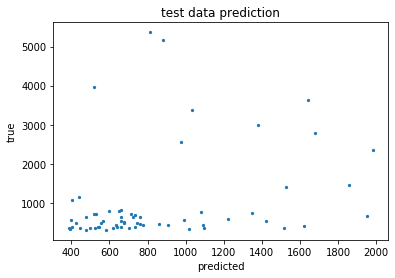

In [153]:
# take a look at the precition results (plotting)
plt.scatter(pred_test_y,y_test, s=5)
plt.title('test data prediction')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

In [154]:
# test on transforming the target to clogs
hdflogy= np.log(np.log(hdf_y+1))
X_train, X_test, y_train, y_test = train_test_split(hdf_scX, hdflogy, test_size=0.3,random_state=12)

In [155]:
RFReg1=RandomForestRegressor(random_state=12,verbose=10)

In [156]:
RFReg1.fit(X_train,y_train)
pred_train_y=RFReg1.predict(X_train)
pred_test_y=RFReg1.predict(X_test)

C:\Users\z0043H7B\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 3 of 10


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


building tree 4 of 10


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


building tree 5 of 10


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s


building tree 6 of 10


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s


building tree 7 of 10


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s


building tree 8 of 10


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s


building tree 9 of 10


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s


building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 

In [157]:
# becareful this is the metrics for log transformed target 
print('MSE score(training):',metrics.mean_squared_error(y_train, pred_train_y))
print('MAE score(training):',metrics.mean_absolute_error(y_train, pred_train_y))
print('MSE score:',metrics.mean_squared_error(y_test, pred_test_y))
print('MAE score:',metrics.mean_absolute_error(y_test, pred_test_y))
print('max error:',metrics.max_error(y_test, pred_test_y))

MSE score(training): 0.0013978203323581676
MAE score(training): 0.026453583525565573
MSE score: 0.009533226836839787
MAE score: 0.07163318419121681
max error: 0.3367764950154559


In [158]:
invt_train_y=np.exp(np.exp(y_train))-1
invt_test_y=np.exp(np.exp(y_test))-1
invt_pred_train_y=np.exp(np.exp(pred_train_y))-1
invt_pred_test_y=np.exp(np.exp(pred_test_y))-1
print('MSE score(training):',metrics.mean_squared_error(invt_train_y, invt_pred_train_y))
print('MAE score(training):',metrics.mean_absolute_error(invt_train_y, invt_pred_train_y))
print('MSE score:',metrics.mean_squared_error(invt_test_y, invt_pred_test_y))
print('MAE score:',metrics.mean_absolute_error(invt_test_y, invt_pred_test_y))
print('accuracy score:',metrics.max_error(invt_test_y, invt_pred_test_y))

MSE score(training): 195541.26782605727
MAE score(training): 186.75206882974362
MSE score: 1276414.6718210224
MAE score: 553.4146782603685
accuracy score: 4781.66149854675


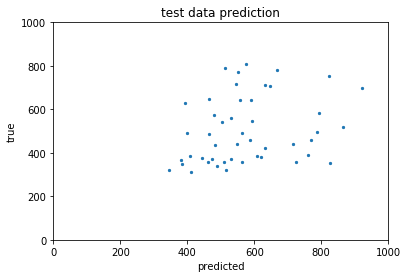

In [159]:
plt.scatter(invt_pred_test_y,invt_test_y, s=5)
plt.title('test data prediction')
plt.xlabel('predicted')
plt.ylabel('true')
plt.xlim([0,1000])
plt.ylim([0,1000])
plt.show()

In [90]:
# narrow down input features
usecolns = list(ldf.columns.values)
usecolns.remove('votes')
usecolns.remove('ev_id')
ldf_X = ldf[usecolns]
ldf_y = ldf['votes']

Text(0, 0.5, 'event counts')

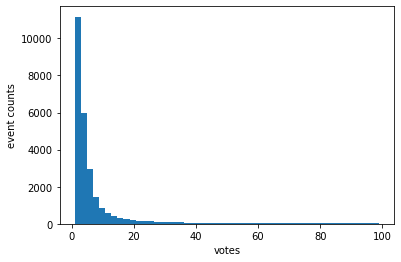

In [91]:
n_bins = 50
# subset votes to those not 1
xx = [c for c in ldf_y if c>0]
fig = plt.hist(xx,bins=n_bins)
#plt.ylim([0,100])
plt.xlabel('votes')
plt.ylabel('event counts')

In [213]:
# do PCA on the low votes
n_keep =3
solver = 'auto'
tolerance = 0.01
rand=12
PCAmod = PCA(n_components=n_keep)#,svd_solver=solver, tol=tolerance, random_state=rand)
#PCAmod = PCA()

In [214]:
PCAmod.fit(ldf_scX)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [215]:
lw_gp=PCAmod.fit_transform(ldf_scX)

In [216]:
lw_gp.shape

(31854, 3)

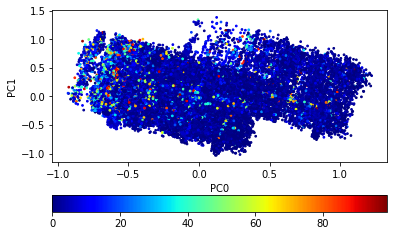

In [230]:
# plot the clustering based on different PComponents
x=lw_gp[:,0]
y=lw_gp[:,1]
# create a color scheme for different vote numbers
plt.scatter(x,y,s=3,c=ldf_y, cmap='jet')
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.colorbar(orientation='horizontal')

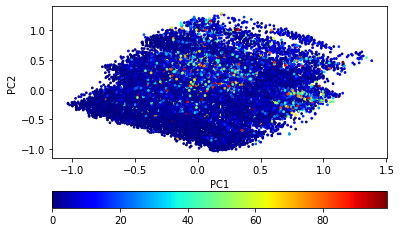

In [231]:
# plot the clustering based on different PComponents
x=lw_gp[:,1]
y=lw_gp[:,2]
# create a color scheme for different vote numbers
plt.scatter(x,y,s=3,c=ldf_y, cmap='jet')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(orientation='horizontal')

In [249]:
# try a 3D figure
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objects as go
# Helix equation
x, y, z = lw_gp[:,0], lw_gp[:,1], lw_gp[:,2]

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        color=z,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# tight layout
#fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

NameError: name 'plotly' is not defined

In [192]:
var=np.cumsum(PCAmod.explained_variance_ratio_)

Text(0, 0.5, 'cumulated ratio explained')

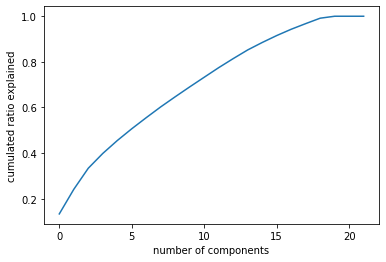

In [196]:

plt.plot(var)
plt.xlabel('number of components')
plt.ylabel('cumulated ratio explained')

In [217]:
PCAmod.get_params

<bound method BaseEstimator.get_params of PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)>